# 프로젝트 설명

xBD_v8_1_0(for_drop_out&batch_8&epoch_200&val_loss_min=103&sampling).ipynb 모델

- F1 스코어: 0.8297
- MIoU: 0.9798
- batch-size: 8
- dropout: 0.20 - 0.40
- data filtering: O
- augment: x
- layer: x
- ModelCheckpoint.saveBestOnly: val_loss min


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 훈련 데이터 파일 압축풀기 (자신의 경로에 맞게 세팅 필요!)

In [ ]:
!tar -xvf '/content/drive/MyDrive/train_images_labels_targets.tar' -C '/content/'

In [ ]:
#샘플링 된 데이터셋
import zipfile
import os

# 2. 압축 파일 경로 설정
zip_file_path = '/content/drive/MyDrive/building-train_images_targets.zip'
extract_to_path = '/content/'

# 3. 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [ ]:
!ls train
# socal-fire_00001357_post_disaster_target.png
# socal-fire_00001357_pre_disaster_target.png

images	targets


# 단일 사진 클래스 개수 확인

In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# 파일 경로(사진경로)
label_image_path = '/content/train/targets/guatemala-volcano_00000000_pre_disaster_target.png'

# 이미지 로드
label_image = Image.open(label_image_path)

# 이미지를 numpy 배열로 변환
label_image_array = np.array(label_image)

# 레이블 이미지의 고유값과 분포 시각화
unique, counts = np.unique(label_image_array, return_counts=True)

# 고유값 분포를 프린트
print("Unique pixel values in label image:", unique)
print("Counts for each value:", counts)


Unique pixel values in label image: [0 1]
Counts for each value: [1032725   15851]


In [ ]:
input_dir = 'train/images'
target_dir = 'train/targets'
img_size = (1024, 1024)
num_classes = 1 # sigmoid 는 1로 설정해야한다
batch_size = 8

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

print(input_img_paths[7])

print(target_img_paths[7])

train/images/guatemala-volcano_00000015_pre_disaster.png
train/targets/guatemala-volcano_00000015_pre_disaster_target.png


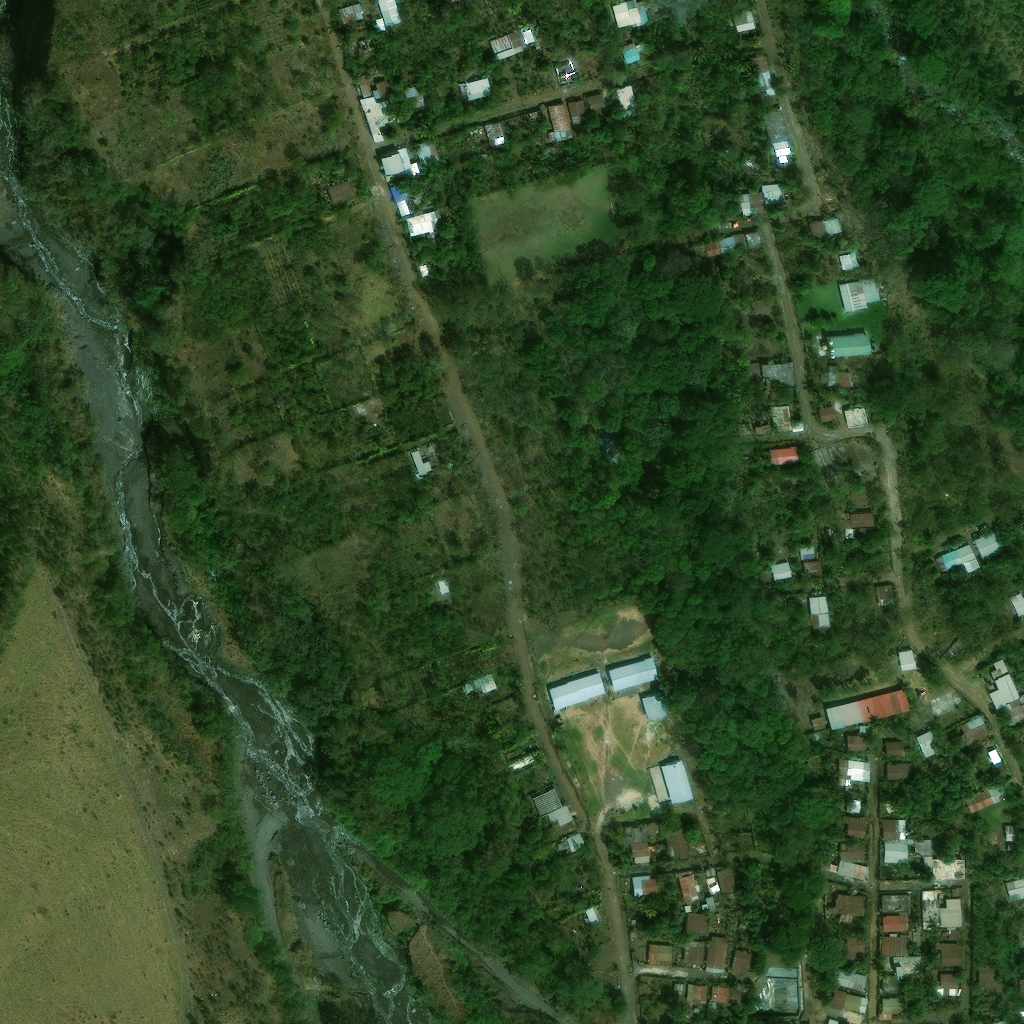

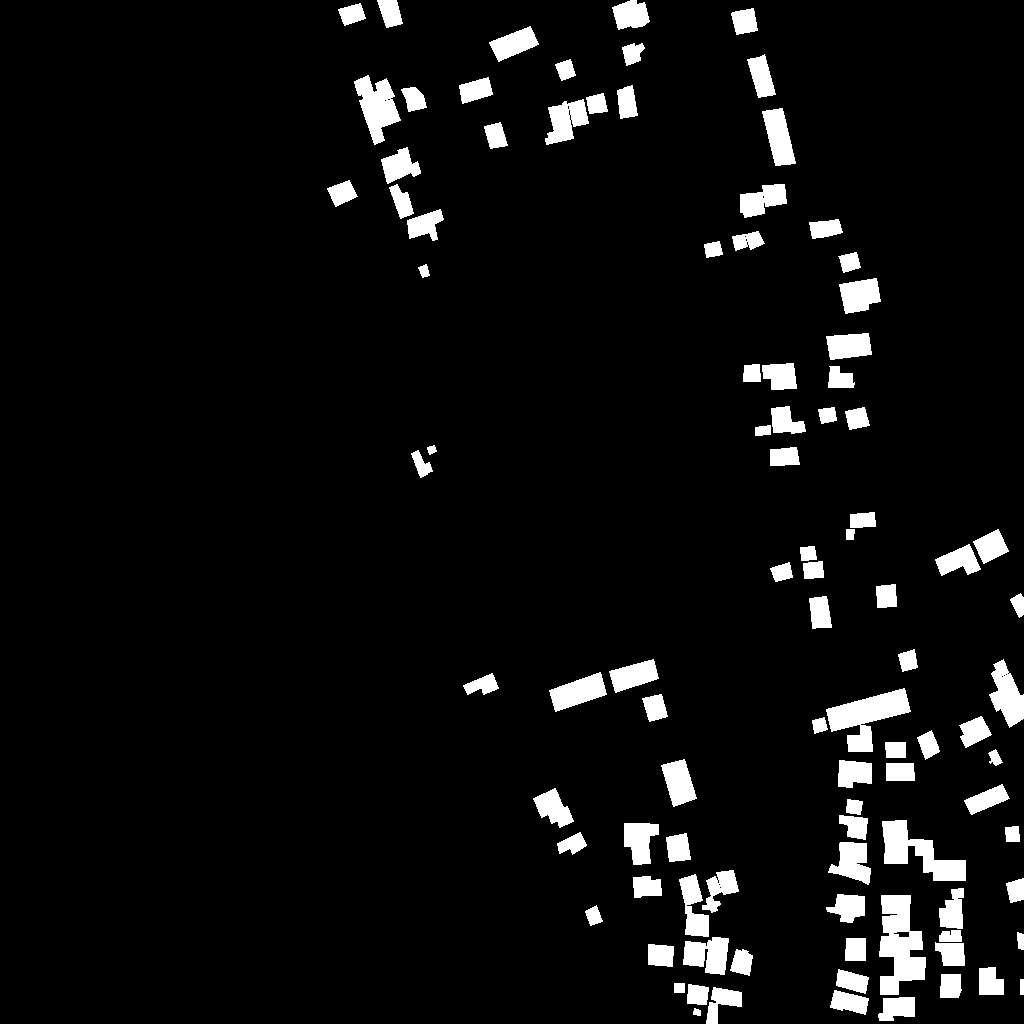

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[7]))
img = ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)
# class0: black class1: white

## 데이터 전처리

In [ ]:
from tensorflow import keras

class xBD(keras.utils.Sequence):
  def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths = input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self, idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path, target_size=self.img_size)
      x[j] = img
    y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path, target_size=self.img_size, color_mode='grayscale')
      y[j] = np.expand_dims(img, 2)

    return x, y


# 옵션 1. 훈련 데이터 50%만 쓸 경우

반드시 50% 또는 100% 코드 중 하나만 실행하세요!

아래의 코드를 실행하세요!


In [ ]:
import random

val_samples = 500 # 검증용 데이터셋 500개
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# input_img_paths랑 target_img_path 50%만 저장
input_img_paths = input_img_paths[:len(input_img_paths)//2]
target_img_paths = target_img_paths[:len(target_img_paths)//2]

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = xBD(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = xBD(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# 옵션2. 훈련 데이터 100% 쓸 경우

반드시 50% 또는 100% 코드 중 하나만 실행하세요!

아래의 코드를 실행하세요!

In [ ]:
import random

val_samples = 100 # 검증용 데이터셋 933개
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = xBD(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = xBD(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 모델 구성

이진 분류 (sigmoid 사용):

출력 채널 수: 1 (하나의 확률 출력으로, 해당 클래스에 속할 확률을 나타냄)
활성화 함수: sigmoid (0과 1 사이의 값으로 출력을 제한, 이 값이 0.5 이상이면 하나의 클래스로, 그렇지 않으면 다른 클래스로 분류)
이진 분류 (softmax 사용):

출력 채널 수: 2 (두 개의 클래스 각각에 대한 확률을 출력)
활성화 함수: softmax (각 출력값을 확률로 변환하여 모든 클래스에 대한 확률의 합이 1이 되도록 함)
다중 클래스 분류 (softmax 사용):

출력 채널 수: 클래스 수에 해당하는 수
활성화 함수: softmax (위와 동일)

In [ ]:
from tensorflow.keras import layers, models

def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size + (3,))

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.20)(x)  # Dropout 추가

    previous_block_activation = x

    for filters in [ 128,256,512]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        x = layers.Dropout(0.4)(x)  # Dropout 추가

        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    for filters in [512,256, 128,64]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.UpSampling2D(2)(x)
        x = layers.Dropout(0.4)(x)  # Dropout 추가

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

model = get_model(img_size, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 32)         0         ['batch_normalization[0][0

## 모델 컴파일 및 학습



In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/xbd_segmentation_v8_1_0.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

epochs = 200
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/200
272/272 [==============================] - ETA: 0s - loss: 0.4946 - accuracy: 0.8928
Epoch 1: val_loss improved from inf to 0.23178, saving model to /content/drive/MyDrive/xbd_segmentation_v8_1_0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


272/272 [==============================] - 283s 699ms/step - loss: 0.4946 - accuracy: 0.8928 - val_loss: 0.2318 - val_accuracy: 0.9389
Epoch 2/200
272/272 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9293
Epoch 2: val_loss did not improve from 0.23178
272/272 [==============================] - 180s 661ms/step - loss: 0.1898 - accuracy: 0.9293 - val_loss: 0.2517 - val_accuracy: 0.9401
Epoch 3/200
272/272 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9409
Epoch 3: val_loss improved from 0.23178 to 0.18763, saving model to /content/drive/MyDrive/xbd_segmentation_v8_1_0.h5
272/272 [==============================] - 181s 664ms/step - loss: 0.1571 - accuracy: 0.9409 - val_loss: 0.1876 - val_accuracy: 0.9479
Epoch 4/200
272/272 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9479
Epoch 4: val_loss improved from 0.18763 to 0.15356, saving model to /content/drive/MyDrive/xbd_segmentation_v8_1_0.h5
272/272 [============

In [ ]:
history.history.keys()
history_dict = history.history

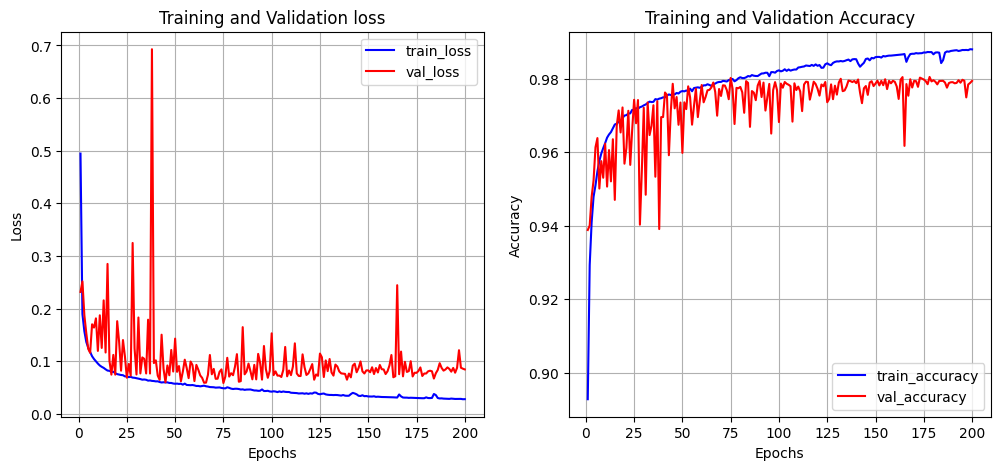

In [ ]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Training and Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']


ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

<ipython-input-24-7319c479d1d2>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


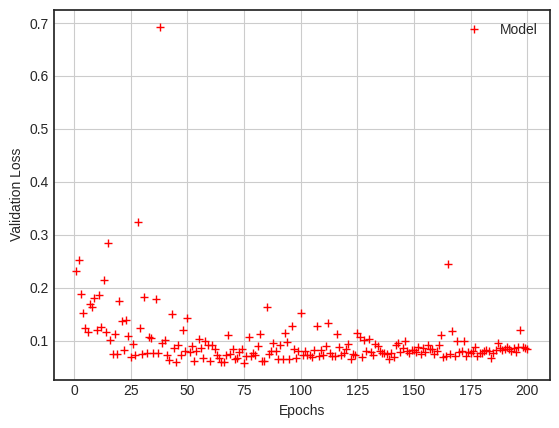

In [ ]:
plt.style.use('seaborn-white')

plt.plot(epochs, val_loss, 'r+', label='Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid()
plt.show()

## 과소적합(Underfitting) / 과대적합(Overfitting)

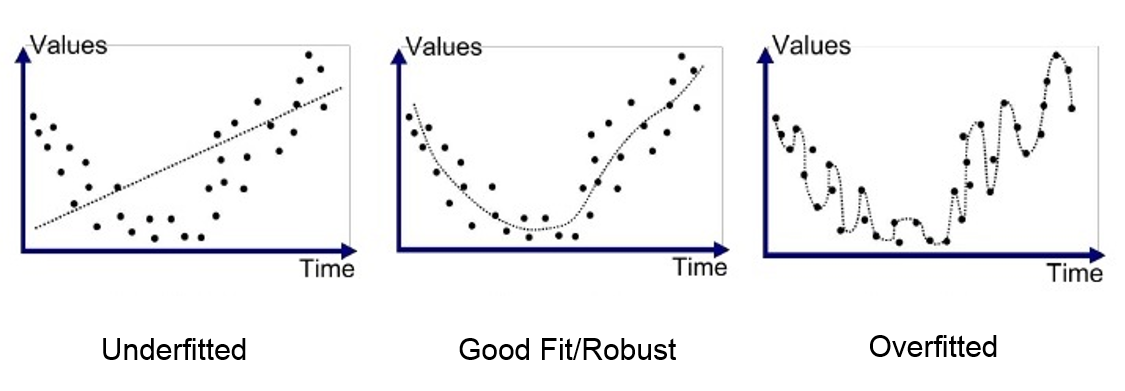

### 과소적합 (Underfitting)

- 학습 데이터를 충분히 학습하지 않아 성능이 매우 안 좋은 경우
- 모델이 지나치게 단순한 경우
- 해결 방안
  - 충분한 학습 데이터 수집
  - 보다 더 복잡한 모델 사용
  - 에폭수(epochs)를 늘려 충분히 학습

### 과대적합 (Overfitting)

- 모델이 학습 데이터에 지나치게 맞추어진 상태
- 새로운 데이터에서는 성능 저하
- 데이터에는 잡음이나 오류가 포함
- 학습 데이터가 매우 적을 경우
- 모델이 지나치게 복잡한 경우
- 학습 횟수가 매우 많을 경우
- 해결방안
  - 다양한 학습 데이터 수집 및 학습
  - 모델 단순화: 파라미터가 적은 모델을 선택하거나, 학습 데이터의 특성 수를 줄임
  - 정규화(Regularization)을 통한 규칙 단순화
  - 적정한 하이퍼 파라미터 찾기

### 과대적합(overfitting)과 과소적합(underfitting) 방지 방법

* 모델의 크기 축소
* 가중치 초기화(Weight Initializer)
* 옵티마이저(Optimizer)
* 배치 정규화(Batch Normalization)
* 규제화(Regularization)
* 드롭아웃(Dropout)

## 모델 평가 및 예측

In [ ]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/drive/MyDrive/xbd_segmentation_v8_1_0.h5')
model.summary()

In [ ]:
!tar -xvf '/content/drive/MyDrive/test_images_labels_targets.tar' -C '/content/'

In [ ]:
input_dir = 'test/images'
target_dir = 'test/targets'
img_size = (1024,1024)
batch_size = 1

input_img_paths = sorted([ os.path.join(input_dir, fname)
                           for fname in os.listdir(input_dir)
                           if fname.endswith('pre_disaster.png')])

target_img_paths = sorted([ os.path.join(target_dir, fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('pre_disaster_target.png')])

test_input_img_paths = input_img_paths
test_target_img_paths = target_img_paths

test_gen = xBD(batch_size, img_size, test_input_img_paths, test_target_img_paths)

In [ ]:
model.evaluate(test_gen)

933/933 [==============================] - 48s 51ms/step - loss: 0.0575 - accuracy: 0.9807


[0.05748507380485535, 0.9807405471801758]

In [ ]:
import math

# 추론용 데이터 제너레이터 클래스 정의
class xBDInference(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return math.ceil(len(self.input_img_paths) / self.batch_size)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        return x


# 2. 테스트셋 이미지 모델 추론

In [ ]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

933/933 [==============================] - 41s 43ms/step


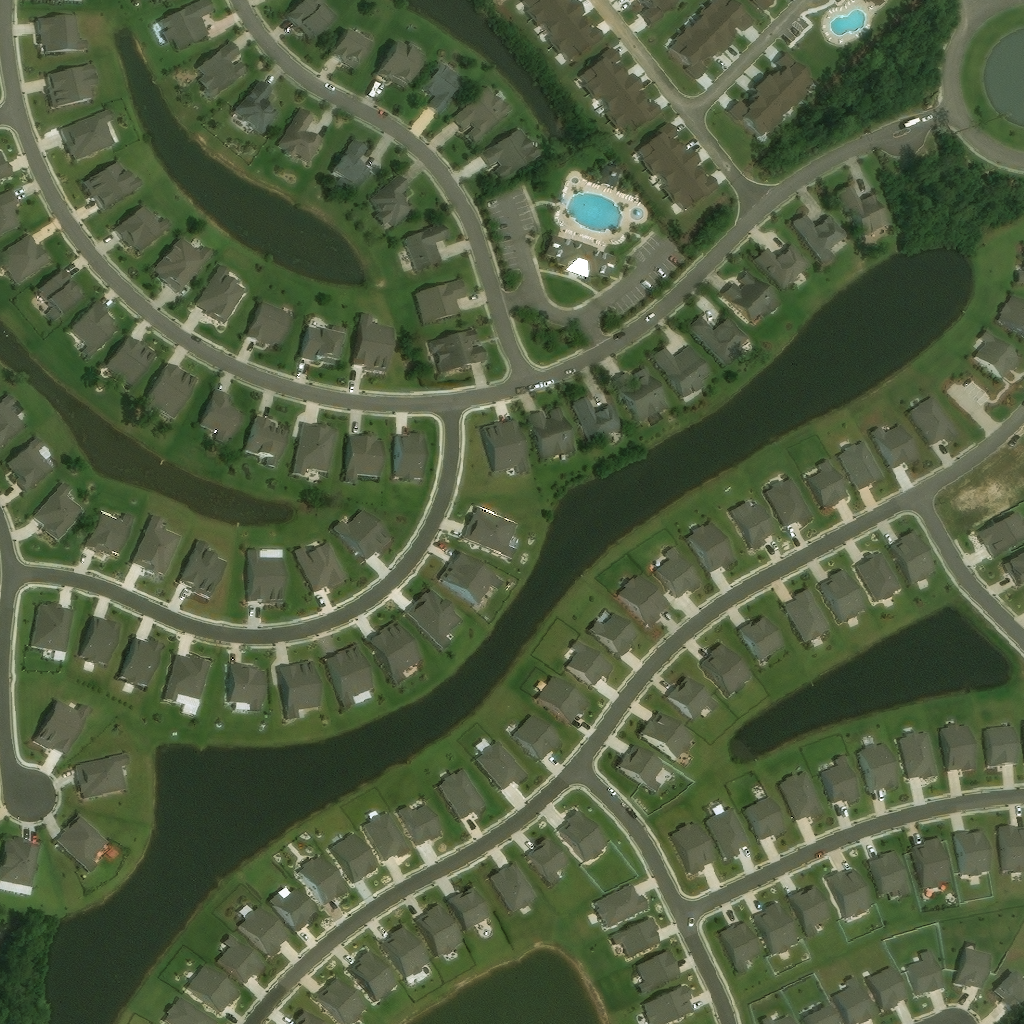

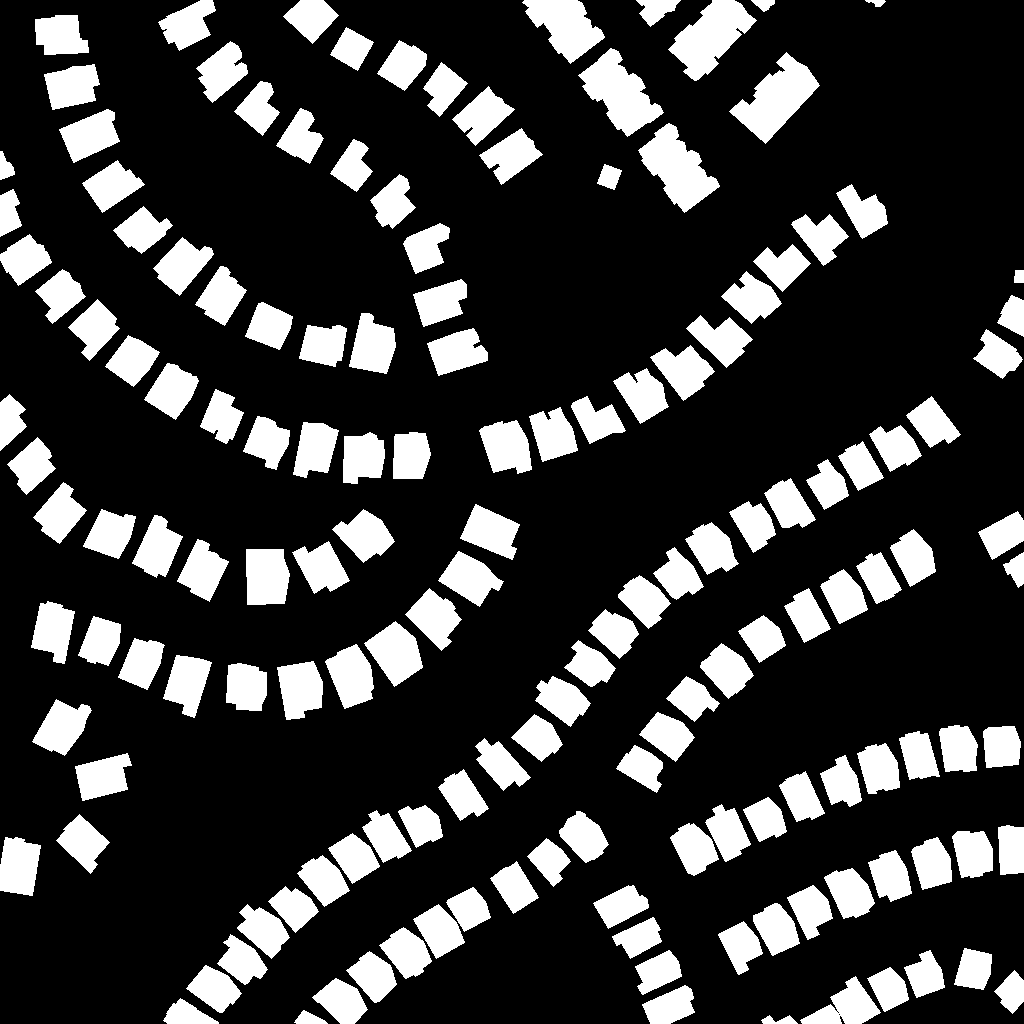

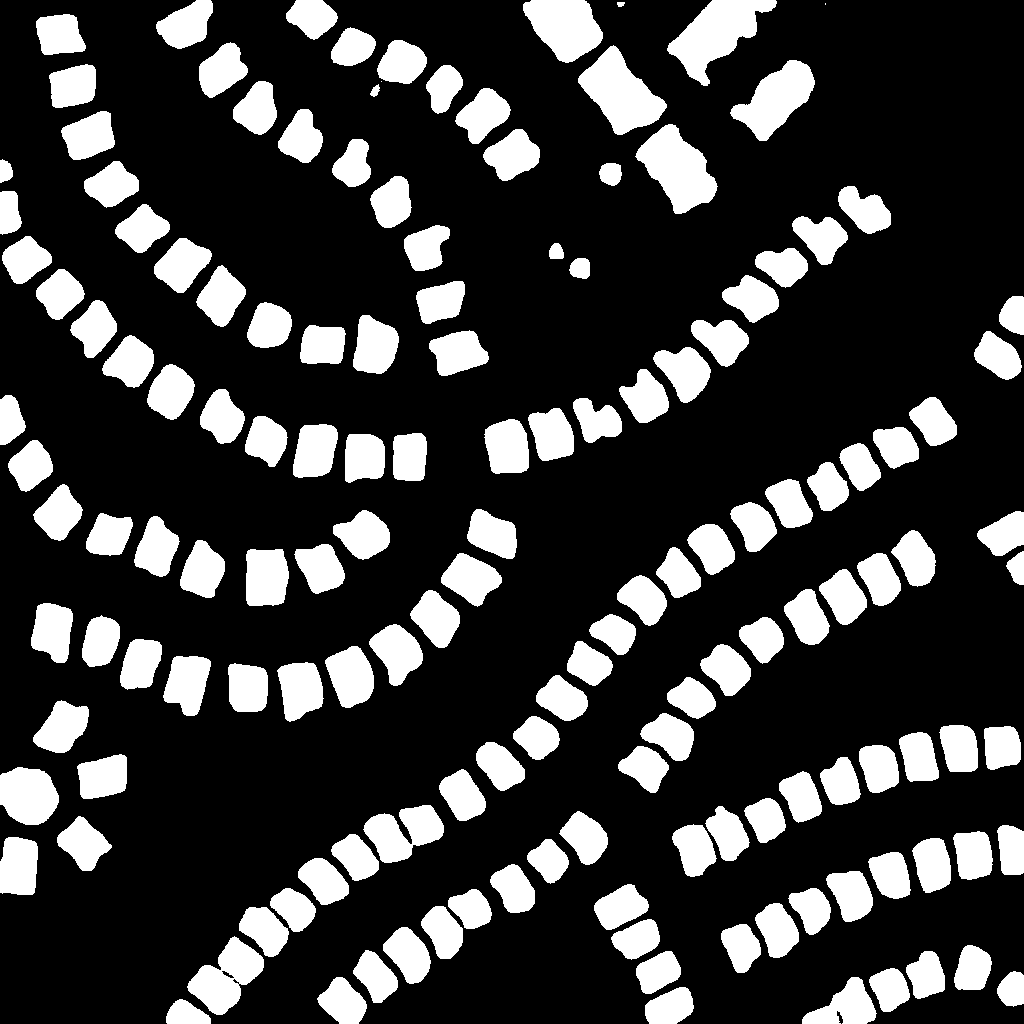

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

def display_mask(i):
  mask = test_preds[i] > 0.5 # sigmoid 사용시
  img = PIL.ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 12

display(Image(filename=test_input_img_paths[i]))
img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
display(img)
display_mask(i)


#DAICON 데이터셋

In [ ]:
from tensorflow.keras.models import load_model

# .h5 파일로부터 모델 로드
model = load_model('/content/drive/MyDrive/xbd_segmentation_v8_1_0.h5')
model.summary()

In [ ]:
input_dir = '/content/test_img'
img_size = (224, 224)
batch_size = 1

input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
])

test_input_img_paths = input_img_paths[:5000]


In [ ]:
test_gen = xBDInference(batch_size, img_size, test_input_img_paths)

test_preds = model.predict(test_gen)

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

def display_mask(i):
  mask = test_preds[i] > 0.5 # sigmoid 사용시
  img = PIL.ImageOps.autocontrast(array_to_img(mask))
  display(img)

# 예측 결과 출력
i = 930

display(Image(filename=test_input_img_paths[i]))
display_mask(i)


## xBD 테스트셋 데이터 추론 마스크 결과 사진 저장

In [ ]:
# 저장할 폴더 경로
save_dir = "/content/drive/MyDrive/xBD/test_predicts_v8_1_0"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [ ]:
def save_mask(i, input_img_paths, save_dir):
    # 입력 이미지 경로에서 파일 이름 추출
    original_filename = os.path.basename(input_img_paths[i])
    # 파일 확장자 제거
    filename_without_extension = os.path.splitext(original_filename)[0]

    # 추론한 마스크 생성
    mask = test_preds[i] > 0.5 # sigmoid 사용시
    img = ImageOps.autocontrast(array_to_img(mask))

    # 마스크를 저장할 파일 이름 설정 (원본 파일 이름에 '_mask' 추가)
    save_path = os.path.join(save_dir, f"{filename_without_extension}_mask.png")

    # 생성된 마스크를 지정된 폴더에 저장
    img.save(save_path)

    print(f"Mask saved at: {save_path}")

In [ ]:
# test_preds에 저장된 모든 마스크에 대해 save_mask 함수를 호출하여 저장
for i in range(len(test_preds)):
    save_mask(i, test_input_img_paths, save_dir)

# MIOU 평가 (xBD test Data)



In [ ]:
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze() # 필요시 차원 축소
# 예측 레이블 준비

# 예측 확률이 0.5 이상인 경우 1로, 그렇지 않으면 0으로 설정
y_pred = (test_preds.squeeze() > 0.5).astype(int)  # 예측 결과 이진화
#y_pred = np.argmax(test_preds, axis=-1)

# mIoU 계산
def mean_iou(y_true, y_pred, num_classes):
  intersection = np.zeros(num_classes)
  union = np.zeros(num_classes)
  for i in range(num_classes):
    intersection[i] = np.logical_and(y_true == i, y_pred == i).sum()
    union[i] = np.logical_or(y_true == i, y_pred == i).sum()
  iou = intersection / np.maximum(union, 1)
  mIoU = np.mean(iou)
  return mIoU

miou_score = mean_iou(y_true, y_pred, num_classes)
print("Mean IoU for the test set is:", miou_score)

Mean IoU for the test set is: 0.9797932081636929


# F1 스코어

In [ ]:
from sklearn.metrics import f1_score

# 예측 레이블 준비 (이진 분류의 경우)
y_true_arrays = [load_img(path, target_size=img_size, color_mode='grayscale') for path in test_target_img_paths]
y_true = np.array([np.expand_dims(np.array(img), axis=-1) for img in y_true_arrays])
y_true = y_true.squeeze()  # 차원 축소, 결과는 0과 1의 레이블

# 예측 확률이 0.5 이상인 경우 1로, 그렇지 않으면 0으로 설정
y_pred = (test_preds.squeeze() > 0.5).astype(int)  # 예측 결과 이진화

# F1 스코어 계산
f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='binary')  # 이진 분류

print("F1 Score for the test set is:", f1)


F1 Score for the test set is: 0.8296554714238982


# 결과

### F1 Score: 0.8297
### MIOU: 0.9798
